# Prescriptive Analytics Project, Winter Term 2024/25

**Group members**:

- Marius Bernahrndt

- Caroline Jungheim

- Simon Scholz

- Christian Gewehr

### Table of Contents
1. [Question 1](#Question1)
2. [Question 2](#Question2)
3. [Question 3](#Question3)
4. [Question 4](#Question4)
5. [Question 5](#Question5)

## Imports

In [1052]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import gurobipy as gp
from gurobipy import GRB

## Question 1 <a name="Question1"></a>

In [1053]:
# Load dataset
df = pd.read_csv("Project_Data.csv", sep=";", index_col="index")
df.head()

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14
index,,,,,,,,,,,,,,
1,1,2,0,1,0,0,2,1,1,2,1,0,0,1
2,1,1,0,1,0,0,2,1,2,2,1,0,0,1
3,1,1,0,1,0,0,2,1,2,2,1,0,0,1
4,1,1,0,1,0,0,2,1,0,2,1,0,0,1
5,1,2,0,1,0,0,2,1,1,2,1,0,0,1


In [1054]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1 to 168
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Week 1   168 non-null    int64
 1   Week 2   168 non-null    int64
 2   Week 3   168 non-null    int64
 3   Week 4   168 non-null    int64
 4   Week 5   168 non-null    int64
 5   Week 6   168 non-null    int64
 6   Week 7   168 non-null    int64
 7   Week 8   168 non-null    int64
 8   Week 9   168 non-null    int64
 9   Week 10  168 non-null    int64
 10  Week 11  168 non-null    int64
 11  Week 12  168 non-null    int64
 12  Week 13  168 non-null    int64
 13  Week 14  168 non-null    int64
dtypes: int64(14)
memory usage: 19.7 KB


As we have 168 hours in a week (24 hours × 7 days = 168), we interpret the index as an ‘hour index’. From this we calculate the day (1-7) and the hour of the day (0-23).

In [1055]:
# Convert DataFrame to long form: convert week columns into a ‘Week’ column
df_melt = df.reset_index().melt(
    id_vars="index",
    var_name="Week",
    value_name="PhysiciansNeeded"
)

# Rename hour index and split into day and hour of day
df_melt.rename(columns={"index": "HourIndex"}, inplace=True)
df_melt["DayOfWeek"] = (df_melt["HourIndex"] - 1) // 24 + 1
df_melt["HourOfDay"] = (df_melt["HourIndex"] - 1) % 24

In [1056]:
# Define shifts
#    night:  0-7
#    early:  8-15
#    late:   16-23
def assign_shift(h):
    if 0 <= h < 8:
        return "night"
    elif 8 <= h < 16:
        return "early"
    else:
        return "late"

df_melt["Shift"] = df_melt["HourOfDay"].apply(assign_shift)

In [1057]:
df_melt

,HourIndex,Week,PhysiciansNeeded,DayOfWeek,HourOfDay,Shift
0,1,Week 1,1,1,0,night
1,2,Week 1,1,1,1,night
2,3,Week 1,1,1,2,night
3,4,Week 1,1,1,3,night
4,5,Week 1,1,1,4,night
...,...,...,...,...,...,...
2347,164,Week 14,2,7,19,late
2348,165,Week 14,1,7,20,late
2349,166,Week 14,1,7,21,late
2350,167,Week 14,1,7,22,late


#### Explorative analyses and visualisations

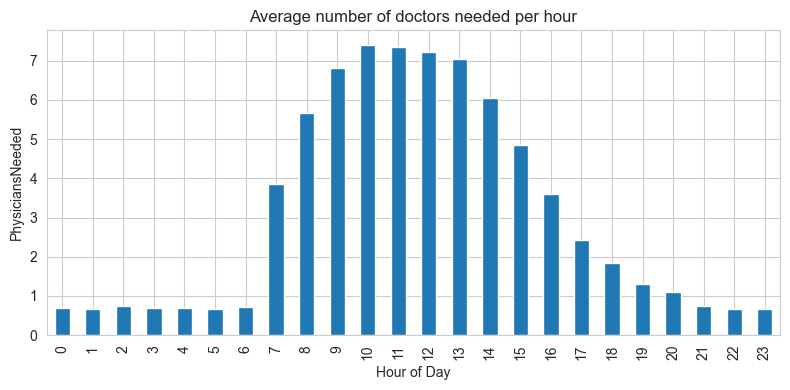

In [1058]:
# Required Physicians on average per hour of the day
avg_by_hour = df_melt.groupby("HourOfDay")["PhysiciansNeeded"].mean()

plt.figure(figsize=(8, 4))
avg_by_hour.plot(kind="bar")
plt.title("Average number of doctors needed per hour")
plt.xlabel("Hour of Day")
plt.ylabel("PhysiciansNeeded")
plt.tight_layout()
plt.show()

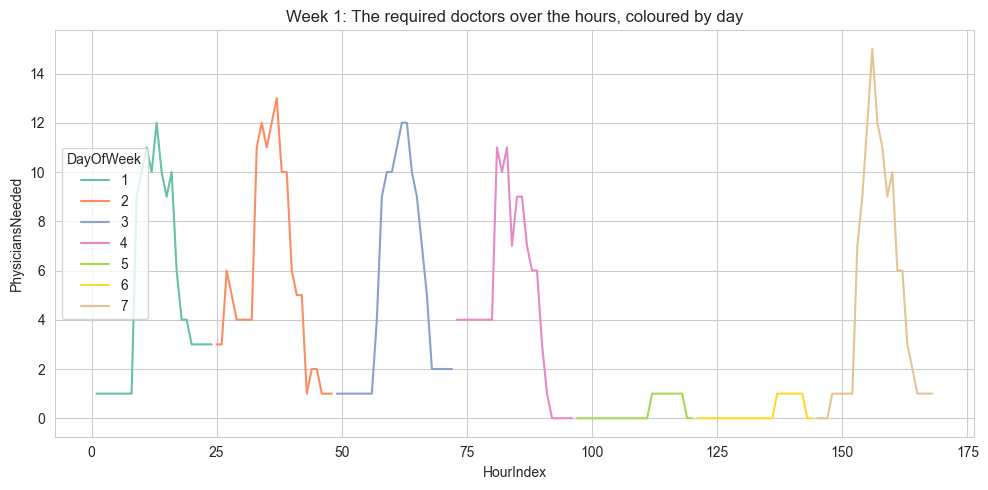

In [1059]:
# The course of the 7 days in a particular week
week1_data = df_melt[df_melt["Week"] == "Week 1"]
plt.figure(figsize=(10,5))
sns.lineplot(
    data=week1_data,
    x="HourIndex",
    y="PhysiciansNeeded",
    hue="DayOfWeek",
    palette="Set2"
)
plt.title("Week 1: The required doctors over the hours, coloured by day")
plt.xlabel("HourIndex")
plt.ylabel("PhysiciansNeeded")
plt.legend(title="DayOfWeek")
plt.tight_layout()
plt.show()

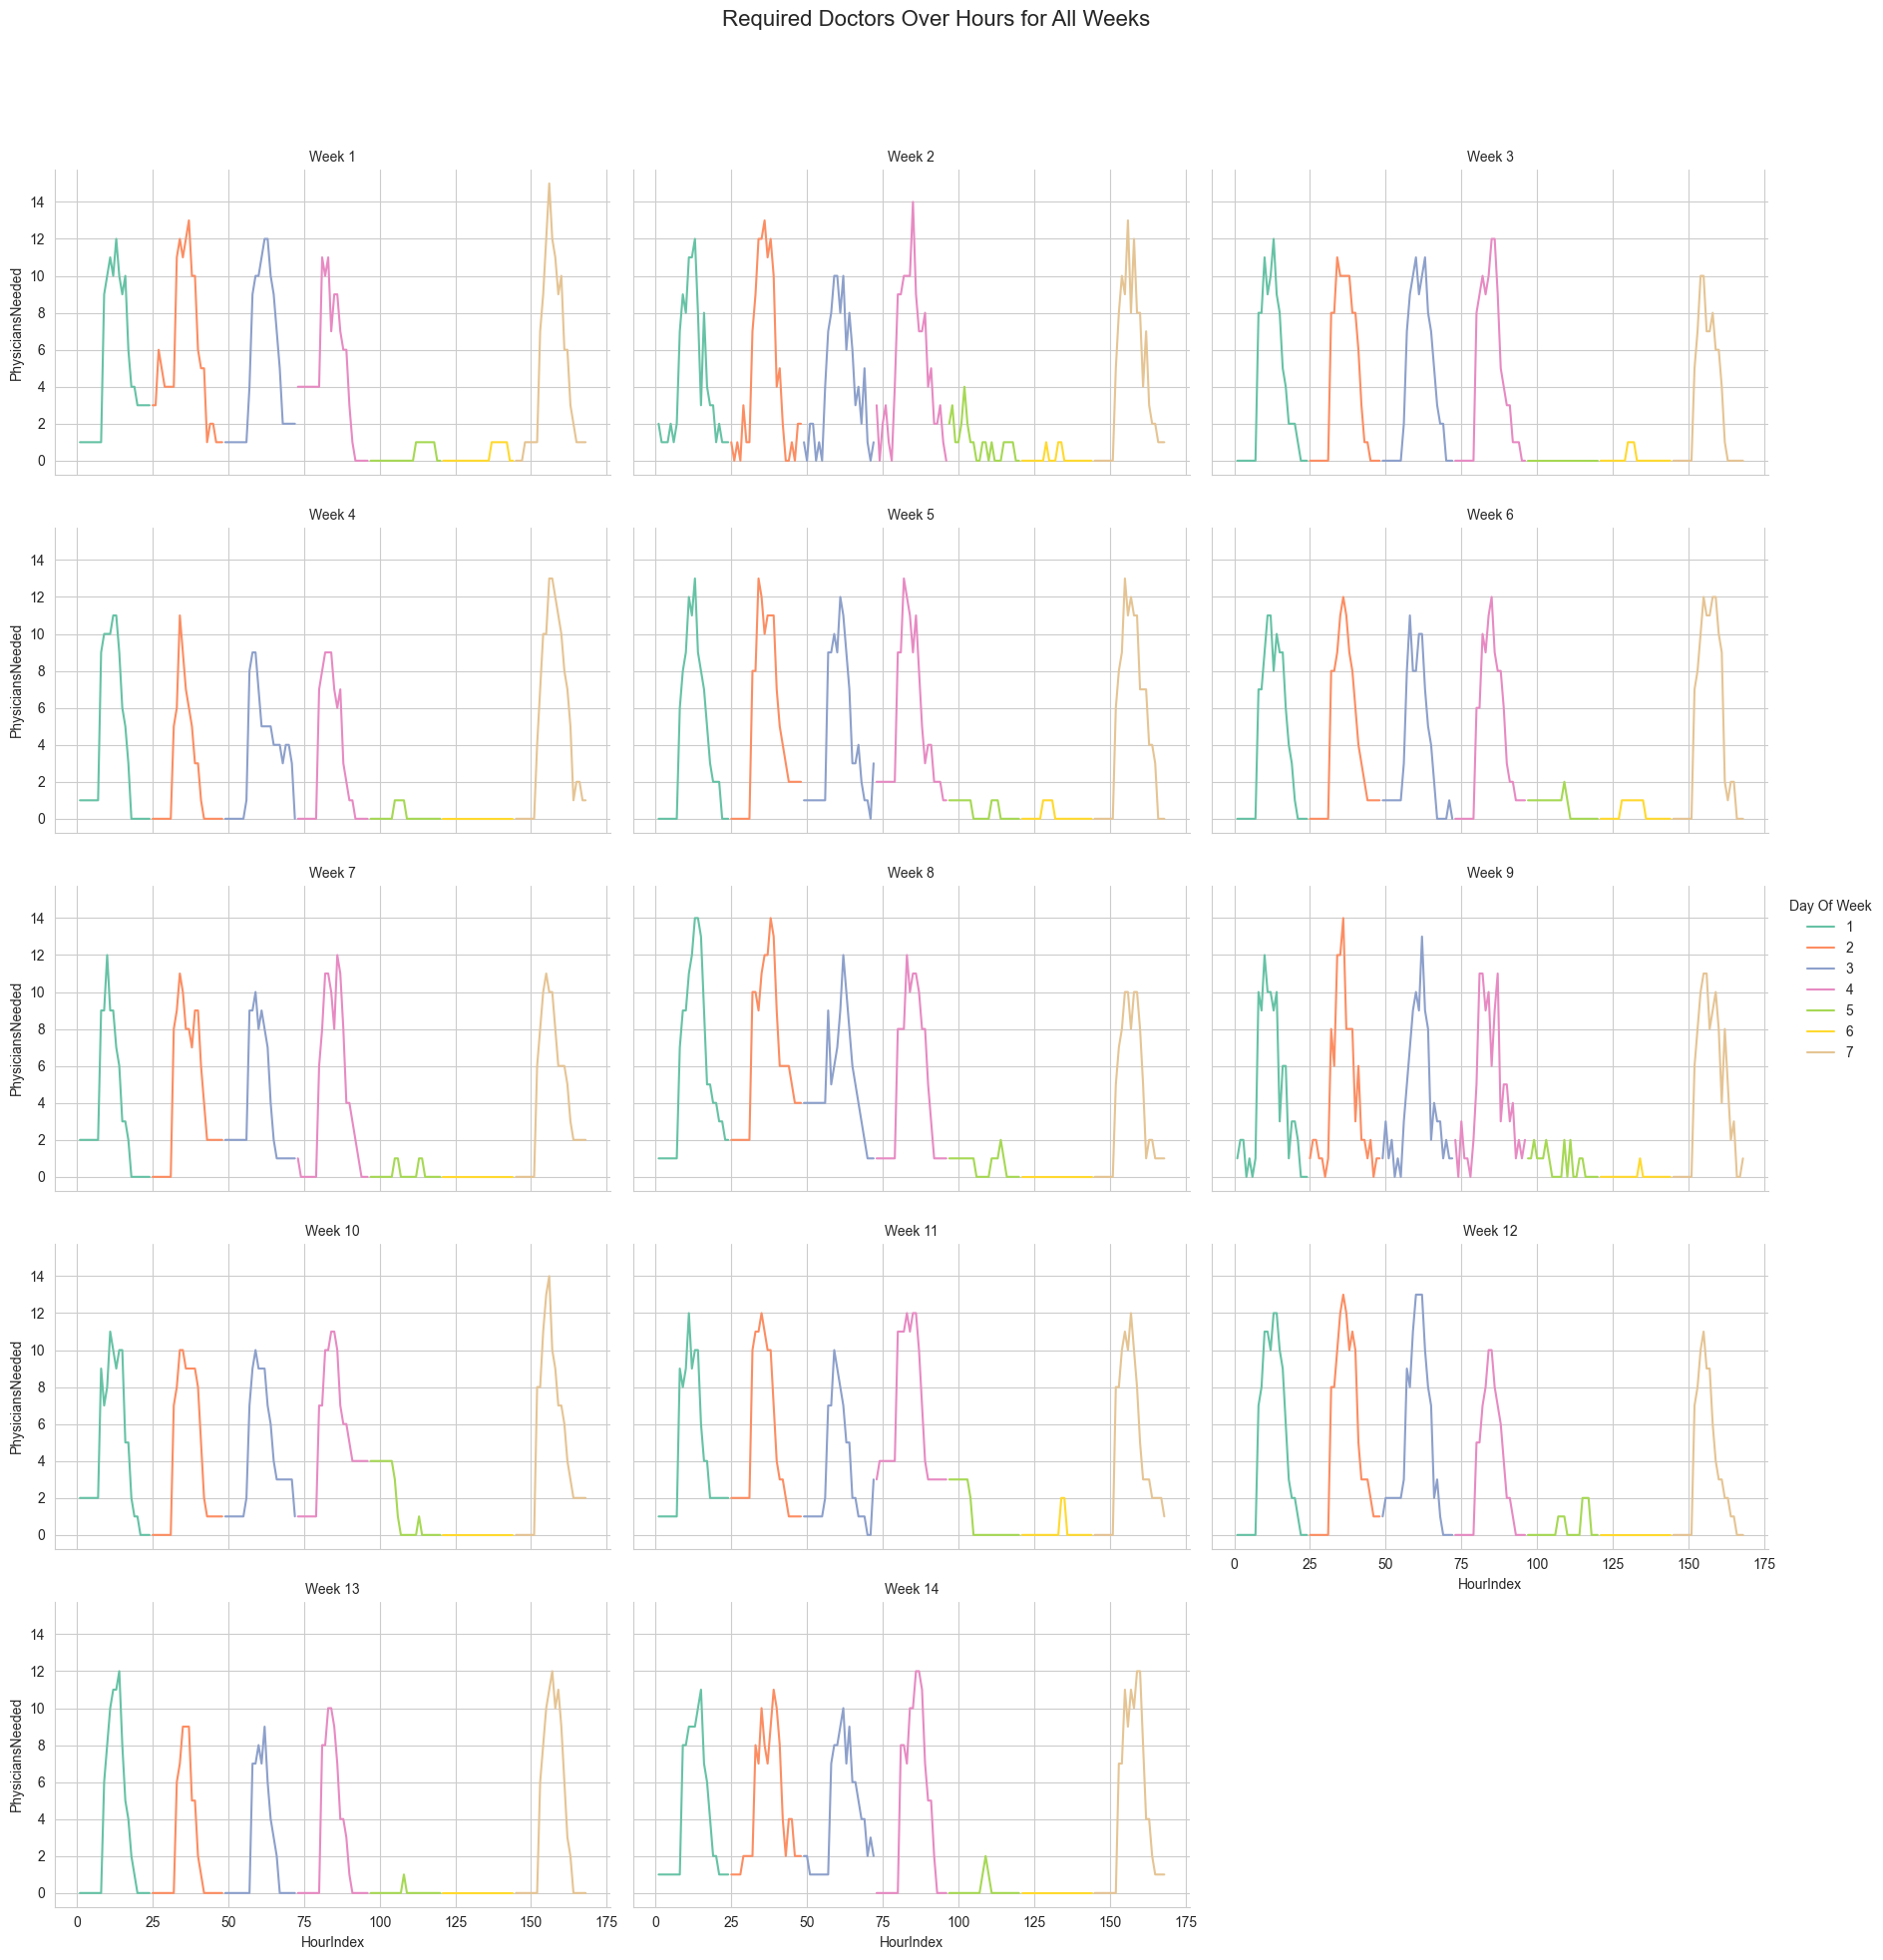

In [1060]:
# The course of the 7 days over all weeks
g = sns.FacetGrid(
    df_melt,
    col="Week",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map(sns.lineplot, "HourIndex", "PhysiciansNeeded", "DayOfWeek", palette="Set2")

g.set_titles("{col_name}")
g.set_axis_labels("HourIndex", "PhysiciansNeeded")
g.add_legend(title="Day Of Week")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Required Doctors Over Hours for All Weeks", fontsize=16)
plt.show()

We can see that the required power on days 5 and 6 is the same and behaves differently from the other days. For this reason, we can assume that it is the weekend of Saturday and Sunday. The data set therefore begins on a Tuesday.

In [1061]:
# Map Weekdays
days_dict = {
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
    7: "Monday",
}

df_melt["DayName"] = df_melt["DayOfWeek"].map(days_dict)

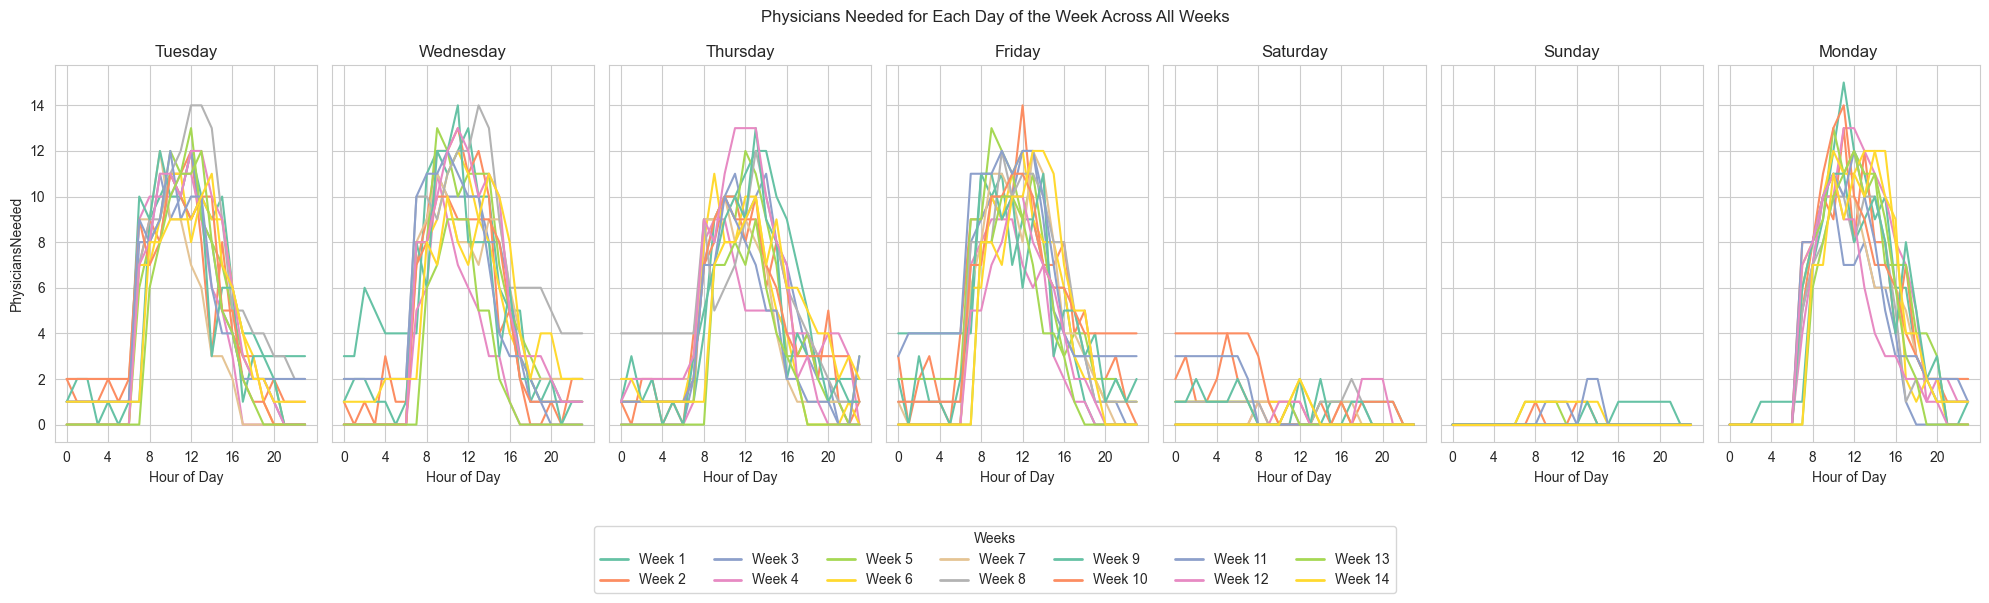

In [1062]:
# Physicians Needed for Each Day of the Week Across All Weeks
week_labels = df_melt["Week"].unique()
fig, axes_line = plt.subplots(1, 7, figsize=(20, 5), sharey=True)

colours = sns.color_palette("Set2", n_colors=len(week_labels))

for i, day_num in enumerate(sorted(days_dict.keys())):
    day_name = days_dict[day_num]
    df_daily = df_melt[df_melt["DayName"] == day_name]

    for j, w_label in enumerate(week_labels):
        df_week = df_daily[df_daily["Week"] == w_label]

        sns.lineplot(
            x="HourOfDay",
            y="PhysiciansNeeded",
            data=df_week,
            color=colours[j],
            ax=axes_line[i],
        )

    axes_line[i].set_title(f"{day_name}")
    if i == 0:
        axes_line[i].set_ylabel("PhysiciansNeeded")
    else:
        axes_line[i].set_ylabel("")
    axes_line[i].set_xlabel("Hour of Day")
    axes_line[i].set_xticks(range(0,24,4))
    axes_line[i].set_xticklabels(range(0,24,4))

handles = [
    plt.Line2D([0], [0], color=colours[i], lw=2, label=week_labels[i])
    for i in range(len(week_labels))
]
fig.legend(
    handles=handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,
    title="Weeks"
)

plt.suptitle("Physicians Needed for Each Day of the Week Across All Weeks")
plt.tight_layout()
plt.show()

In [1063]:
# Mean, Median, STD, Min, Max
# Per Shift
stats_by_shift = df_melt.groupby("Shift")["PhysiciansNeeded"].agg(
    mean="mean",
    median="median",
    std="std",
    min="min",
    max="max"
).reset_index()

print("\nStatistical key figures per shift (all weeks/days together):")
print(stats_by_shift)


Statistical key figures per shift (all weeks/days together):
   Shift      mean  median       std  min  max
0  early  6.545918     8.0  4.434042    0   15
1   late  1.544643     1.0  1.870125    0    9
2  night  1.093112     0.0  1.905227    0   11


In [1064]:
# Per Day and Shift
stats_by_day_shift = df_melt.groupby(["DayName", "Shift"])["PhysiciansNeeded"].agg(
    mean="mean",
    median="median",
    std="std",
    min="min",
    max="max"
).reset_index()

print("\n--- Statistical key figures per (Day, Shift) ---")
print(stats_by_day_shift)


--- Statistical key figures per (Day, Shift) ---
      DayName  Shift      mean  median       std  min  max
0      Friday  early  9.062500     9.0  2.182160    3   14
1      Friday   late  2.125000     2.0  1.959615    0    8
2      Friday  night  1.705357     1.0  2.399844    0   11
3      Monday  early  9.464286    10.0  2.151591    3   15
4      Monday   late  2.312500     2.0  2.160377    0    9
5      Monday  night  0.642857     0.0  1.859270    0    8
6    Saturday  early  0.348214     0.0  0.595929    0    3
7    Saturday   late  0.232143     0.0  0.501927    0    2
8    Saturday  night  0.937500     0.5  1.254048    0    4
9      Sunday  early  0.187500     0.0  0.435606    0    2
10     Sunday   late  0.053571     0.0  0.226182    0    1
11     Sunday  night  0.017857     0.0  0.133027    0    1
12   Thursday  early  8.321429     9.0  2.286720    0   13
13   Thursday   late  2.267857     2.0  1.926497    0    9
14   Thursday  night  1.267857     1.0  1.114864    0    4
15    

In [1065]:
# Differentiate between weekday and weekend
weekday_mapping = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
df_melt["is_weekday"] = df_melt["DayName"].map(lambda x: 1 if weekday_mapping[x] <= 5 else 0)

df_weekday = df_melt[df_melt["is_weekday"] == 1]
df_weekend = df_melt[df_melt["is_weekday"] == 0]
print(f"Working day entries: {len(df_weekday)} | Weekend entries: {len(df_weekend)}")

Working day entries: 1680 | Weekend entries: 672


#### Clustering

In [1066]:
# Prepare Columns and create Shifts
df_day_shift = df_melt.groupby(["Week", "DayName", "Shift"])["PhysiciansNeeded"].mean().reset_index()

df_day_shift_pivot = df_day_shift.pivot_table(
    index=["Week", "DayName"],
    columns="Shift",
    values="PhysiciansNeeded"
).reset_index()

df_day_shift_pivot = df_day_shift_pivot[["Week", "DayName", "night", "early", "late"]]

print("\n(Week, DayName) -> night/early/late:")
display(df_day_shift_pivot.head(10))


(Week, DayName) -> night/early/late:


Shift,Week,DayName,night,early,late
0,Week 1,Friday,4.000,8.750,1.250
1,Week 1,Monday,0.625,10.625,2.625
2,Week 1,Saturday,0.000,0.125,0.750
3,Week 1,Sunday,0.000,0.000,0.750
4,Week 1,Thursday,1.000,9.750,3.875
5,Week 1,Tuesday,1.000,10.125,3.625
6,Week 1,Wednesday,4.125,10.625,2.250
7,Week 10,Friday,1.750,9.000,4.375
8,Week 10,Monday,1.000,9.875,2.875
9,Week 10,Saturday,4.000,0.500,0.125


In [1067]:
# Standardize the data
shift_cols = ["night", "early", "late"]
X = df_day_shift_pivot[shift_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

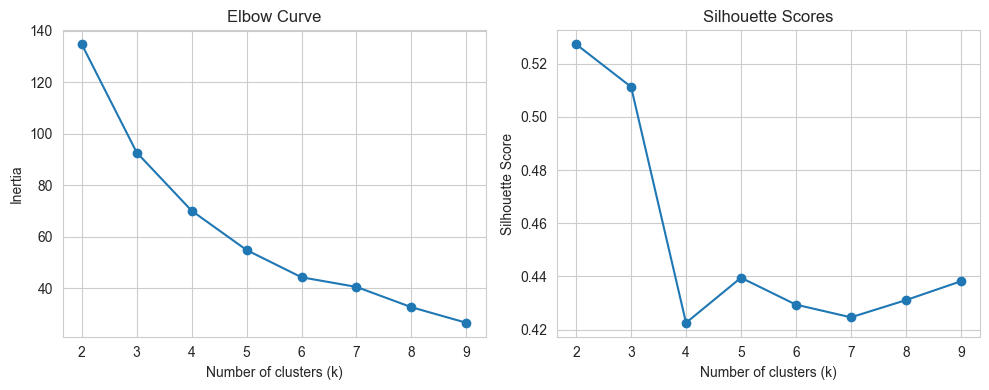


Elbow-Scores: [134.65922574695242, 92.62915546358327, 70.02269554708919, 54.7620598596995, 44.18638784137421, 40.450039292909565, 32.57135012511095, 26.518973844928478]
Silhouette-Scores: [0.5272479991398622, 0.511236243253153, 0.4225930212460223, 0.4395314240187819, 0.4294184393680335, 0.42465020942483106, 0.4310974641215704, 0.4381818464493716]


In [1068]:
# Elbow + Silhouette to decide how many Clusters there are
K_range = range(2, 10)
inertia_list = []
silhouette_list = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)

    inertia_list.append(km.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_list.append(sil_score)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(K_range, inertia_list, 'o-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Curve")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_list, 'o-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores")

plt.tight_layout()
plt.show()

print("\nElbow-Scores:", inertia_list)
print("Silhouette-Scores:", silhouette_list)

The elbow method is used to determine the optimum number of clusters by identifying the point at which a further reduction in inertia no longer brings any significant improvement. In this case, there is no clear kink in the elbow curve, which is why the silhouette score is also used, which evaluates the cluster quality based on the highest possible value. The combination of both approaches shows that **k=3** offers the best balance between low inertia and high cluster quality, which is why the analysis is continued with 3 clusters.

In [1069]:
# Cluster with best k from elbow method
best_k = 3

kmeans_final = KMeans(n_clusters=best_k, random_state=42)
df_day_shift_pivot["Cluster"] = kmeans_final.fit_predict(X_scaled)

print(f"\n--- Final Cluster Assignment (k={best_k}) ---")
df_day_shift_pivot


--- Final Cluster Assignment (k=3) ---


Shift,Week,DayName,night,early,late,Cluster
0,Week 1,Friday,4.000,8.750,1.250,2
1,Week 1,Monday,0.625,10.625,2.625,0
2,Week 1,Saturday,0.000,0.125,0.750,1
3,Week 1,Sunday,0.000,0.000,0.750,1
4,Week 1,Thursday,1.000,9.750,3.875,0
...,...,...,...,...,...,...
93,Week 9,Saturday,1.250,0.500,0.250,1
94,Week 9,Sunday,0.000,0.125,0.000,1
95,Week 9,Thursday,1.375,8.750,2.125,0
96,Week 9,Tuesday,2.125,8.625,1.875,0


In [1070]:
# Map cluster to dataset
cluster_dict = df_day_shift_pivot.set_index(["Week", "DayName"])["Cluster"].to_dict()

def map_cluster(row):
    return cluster_dict.get((row["Week"], row["DayName"]), np.nan)

df_melt["Cluster"] = df_melt.apply(map_cluster, axis=1)

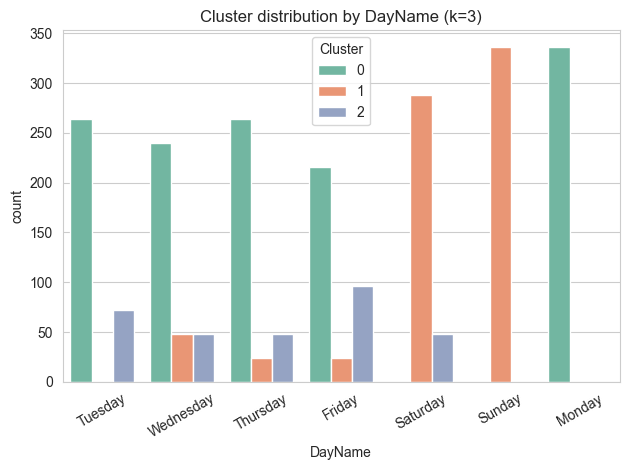

In [1071]:
# Countplot
sns.countplot(
    x="DayName",
    hue="Cluster",
    data=df_melt,
    palette="Set2"
)
plt.title(f"Cluster distribution by DayName (k={best_k})")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

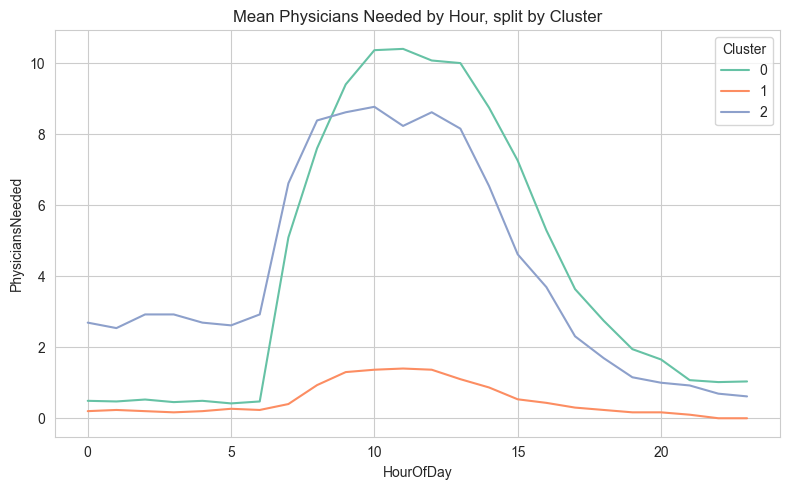

In [1072]:
# Lineplot
df_cluster_agg = df_melt.groupby(["Cluster","HourOfDay"])["PhysiciansNeeded"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(
    x="HourOfDay",
    y="PhysiciansNeeded",
    hue="Cluster",
    data=df_cluster_agg,
    palette="Set2"
)
plt.title("Mean Physicians Needed by Hour, split by Cluster")
plt.xlabel("HourOfDay")
plt.ylabel("PhysiciansNeeded")
plt.tight_layout()
plt.show()

In [1073]:
# Mean, median, standard deviation, maximum and minimum for each shift type in each cluster
stats_by_cluster_shift = (
    df_melt.groupby(["Cluster", "Shift"])["PhysiciansNeeded"]
    .agg(["mean", "median", "std", "max", "min"])
    .reset_index()
)

print(stats_by_cluster_shift)

   Cluster  Shift      mean  median       std  max  min
0        0  early  9.229545     9.0  2.169270   15    1
1        0   late  2.300000     2.0  1.954144    9    0
2        0  night  1.052273     0.0  1.951460   10    0
3        1  early  1.108333     0.0  2.381223   11    0
4        1   late  0.175000     0.0  0.486857    3    0
5        1  night  0.237500     0.0  0.618618    5    0
6        2  early  7.740385     9.0  3.891727   14    0
7        2   late  1.509615     1.0  1.717953    8    0
8        2  night  3.240385     3.0  2.026500   11    0


### Cluster Interpretation

1. **Cluster 0** – **High Demand**
   - **Early Shift (mean ~9.23, max 15)** stands out with the highest requirement.
   - **Night (1.05) and Late (2.30)** remain moderate.

>**Insight**: Typical weekday pattern with a significant daytime (early) demand, e.g., for scheduled surgeries or consultations.

2. **Cluster 1** – **Low Demand**
   - Consistently low values in **night (0.24), early (1.11),** and **late (0.18)**.
   - Often zero-demand in many observations (min = 0 for all shifts).

> **Insight**: Likely **weekend-like days** or otherwise very quiet days with minimal staffing needs across all shifts.

3. **Cluster 2** – **Medium Demand**
   - **Night** is noticeably higher at **3.24** on average, while **Early** remains at **7.74** (less than Cluster 0, but still considerable).
   - **Late** shift stands at **1.51**.

> **Insight**: Days with **increased night demand** (e.g., emergencies or on-call duties) but not the maximum early shift requirement seen in Cluster 0.


### Weekend and Weekday

By reviewing the `DayName` column (e.g., Monday, Tuesday, etc.), **Saturdays and Sundays** most frequently fall into **Cluster 1**, aligning with very low values across all shifts. This confirms that weekends tend to require fewer physicians. In contrast, **Mondays and other weekdays** often appear in Cluster 0 or 2, reflecting higher overall demand—especially during the early shift and, for Cluster 2, an elevated night demand.


### Conclusion

- **Cluster 1**: Minimal demand in every shift — a clear weekend signature.
- **Cluster 0**: Significant peaks in the early shift, representing typical busy weekdays.
- **Cluster 2**: Notably higher night requirements alongside a substantial (but not maximum) early shift demand.

These three clusters allow us to categorize the days based on staffing needs for each shift. Such insights can guide more targeted physician scheduling, ensuring sufficient coverage especially on high-demand weekdays (Cluster 0) and special night-demand days (Cluster 2) while recognizing that certain days (Cluster 1) require minimal staffing.


## Question 2 <a name="Question2"></a>

## Mathematical Model Description

### Variables:
1. $x[p, d, s] ∈ {0,1}$: Binary decision variable, where:
   - $x[p, d, s] = 1$ if physician $p$ works shift $s$ on day $d$.
   - $x[p, d, s] = 0$ otherwise.

2. $y[p] ∈ {0,1}$: Binary variable indicating whether physician $p$ is used at all:
   - $y[p] = 1$ if $p$ is assigned any shifts during the week.
   - $y[p] = 0$ otherwise.

3. $b[p, s] ∈ {0,1}$: Binary variable for shift-type allocation:
   - $b[p, s] = 1$ if physician $p$ is allowed to work shift type $s$ in the week.
   - Each physician can only work two shift types.

4. ${day\_worked}[p, d] ∈ {0,1}$: Auxiliary variable to track whether physician $p$ works on day $d$.

5. $z[p, d] ∈ {0,1}$: Binary variable to enforce two consecutive days off:
   - $z[p, d] = 1$ if physician $p$ has both day $d$ and $d+1$ off.
   - $z[p, d] = 0$ otherwise.

---

### Objective:
Minimize the total number of physicians:
$$\[
\text{Minimize: } \sum_{p} y[p]
\]$$

---

### Constraints:
1. **Demand Satisfaction**:
   - Ensure that demand for each day and shift is met:
   $$\[
   \sum_{p} x[p, d, s] \geq \text{demand}[d, s], \, \forall d, s
   \]$$

2. **40-Hour Weekly Limit**:
   - Each physician can work at most 5 shifts per week:
   $$\[
   \sum_{d, s} x[p, d, s] \leq 5, \, \forall p
   \]$$

3. **Two Shift Types Per Week**:
   - Physicians are restricted to at most two shift types:
   $$\[
   \sum_{s} b[p, s] = 2, \, \forall p
   \]$$
   $$\[
   x[p, d, s] \leq b[p, s], \, \forall p, d, s
   \]$$

4. **No More Than 3 Consecutive Night Shifts**:
   - For every 4 consecutive days, no more than 3 night shifts:
   $$\[
   \sum_{d' \in \{d, d+1, d+2, d+3\}} x[p, d', \text{Night}] \leq 3, \, \forall p, d
   \]$$

5. **10-Hour Rest Requirement**:
   - Late shift on day $d$ prevents an early shift on day $d+1$:
   $$\[
   x[p, d, \text{Late}] + x[p, d+1, \text{Early}] \leq 1, \, \forall p, d
   \]$$

6. **Two Consecutive Days Off**:
   - Ensure each physician has at least one pair of consecutive days off:
   $$\[
   \sum_{d} z[p, d] \geq 1, \, \forall p
   \]$$
   Where:
   $$\[
   z[p, d] \leq 1 - {day\_worked}[p, d] \, \forall p, d
   \]$$
   $$\[
   z[p, d] \leq 1 - {day\_worked}[p, d+1] \, \forall p, d
   \]$$


Average demand per shift per day:
Shift         early      late     night
DayName                                
Tuesday    9.169643  1.767857  1.517857
Wednesday  9.267857  2.053571  1.562500
Thursday   8.321429  2.267857  1.267857
Friday     9.062500  2.125000  1.705357
Saturday   0.348214  0.232143  0.937500
Sunday     0.187500  0.053571  0.017857
Monday     9.464286  2.312500  0.642857


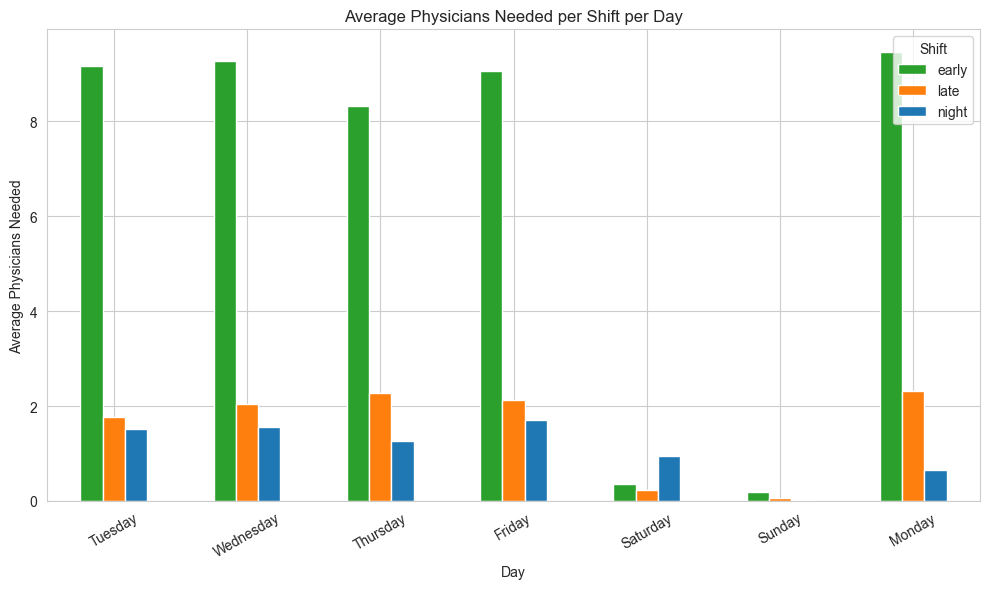

In [1074]:
# Mean values from stats_by_day_shift
day_order = list(days_dict.values())

avg_shift_day = stats_by_day_shift.pivot(
    index="DayName",
    columns="Shift",
    values="mean"
)

avg_shift_day = avg_shift_day.reindex(day_order)

print("Average demand per shift per day:")
print(avg_shift_day)

# Colors for shifts
shift_colors = {"Night": "#1f77b4", "Early": "#2ca02c", "Late": "#ff7f0e"}

# Barplot
avg_shift_day.plot(
    kind="bar",
    figsize=(10, 6),
    color=[shift_colors["Early"], shift_colors["Late"], shift_colors["Night"]]
)
plt.title("Average Physicians Needed per Shift per Day")
plt.ylabel("Average Physicians Needed")
plt.xlabel("Day")
plt.xticks(rotation=30)
plt.legend(title="Shift")
plt.tight_layout()
plt.show()

In [1075]:
demand = {
    'Tuesday': {'Early': 9, 'Late': 2, 'Night': 2},
    'Wednesday': {'Early': 9, 'Late': 2, 'Night': 2},
    'Thursday': {'Early': 8, 'Late': 2, 'Night': 1},
    'Friday': {'Early': 9, 'Late': 2, 'Night': 2},
    'Saturday': {'Early': 0, 'Late': 0, 'Night': 1},
    'Sunday': {'Early': 0, 'Late': 0, 'Night': 0},
    'Monday': {'Early': 9, 'Late': 2, 'Night': 1},
}

# Perhaps we should use this demand because personal can only round up ???
# demand = {
#     'Tuesday': {'Early': 10, 'Late': 2, 'Night': 2},
#     'Wednesday': {'Early': 10, 'Late': 3, 'Night': 2},
#     'Thursday': {'Early': 9, 'Late': 3, 'Night': 2},
#     'Friday': {'Early': 10, 'Late': 3, 'Night': 2},
#     'Saturday': {'Early': 1, 'Late': 1, 'Night': 1},
#     'Sunday': {'Early': 1, 'Late': 1, 'Night': 1},
#     'Monday': {'Early': 10, 'Late': 3, 'Night': 1},
# }

Here, we first calculated the averages to determine how many physicians are needed per day and shift. The demand, rounded to the nearest integer, was then stored in a dictionary, providing a clear and practical representation of physician requirements for scheduling.

In [1076]:
def physician_scheduling(physicians, demand, DAYS, SHIFTS):
    m = gp.Model("PhysicianScheduling")

    # Decision variables
    x = m.addVars(physicians, DAYS, SHIFTS, vtype=GRB.BINARY, name="x")
    y = m.addVars(physicians, vtype=GRB.BINARY, name="y")
    b = m.addVars(physicians, SHIFTS, vtype=GRB.BINARY, name="b")
    day_worked = m.addVars(physicians, DAYS, vtype=GRB.BINARY, name="day_worked")
    z = m.addVars(physicians, DAYS, vtype=GRB.BINARY, name="z_consecutiveOff")

    # Objective
    m.setObjective(gp.quicksum(y[p] for p in physicians), GRB.MINIMIZE)

    # Constraints
    # 1. Demand Satisfaction
    for d in DAYS:
        for s in SHIFTS:
            m.addConstr(
                gp.quicksum(x[p, d, s] for p in physicians) >= demand[d][s],
                name=f"demand_{d}_{s}"
            )
            m.addConstr(
                gp.quicksum(x[p, d, s] for p in physicians) >= 1,
                name=f"at_least_one_per_shift_{d}_{s}"
            )

    # Ensure y[p] is 1 if physician p works any shift
    for p in physicians:
        m.addConstr(
            gp.quicksum(x[p, d, s] for d in DAYS for s in SHIFTS) <= 5 * y[p],
            name=f"activate_y_{p}"
        )

    # 2. 40-Hour Weekly Limit
    for p in physicians:
        m.addConstr(
            gp.quicksum(x[p, d, s] for d in DAYS for s in SHIFTS) <= 5,
            name=f"max_shifts_{p}"
        )

    # 3. Two Shift Types Per Week
    for p in physicians:
        m.addConstr(
            gp.quicksum(b[p, s] for s in SHIFTS) <= 2,
            name=f"max_shift_types_{p}"
        )
        for d in DAYS:
            for s in SHIFTS:
                m.addConstr(
                    x[p, d, s] <= b[p, s],
                    name=f"shift_type_assignment_{p}_{d}_{s}"
                )

    # 4. No More Than 3 Consecutive Night Shifts (including cyclic transition)
    for p in physicians:
        for i in range(len(DAYS) - 3):
            m.addConstr(
                gp.quicksum(x[p, DAYS[i + j], "Night"] for j in range(4)) <= 3,
                name=f"Max3ConsecutiveNights_p{p}_start{i}"
            )
        # Cyclic transition: Friday -> Monday
        m.addConstr(
            gp.quicksum(x[p, day, "Night"] for day in ["Friday", "Saturday", "Sunday", "Monday"]) <= 3,
            name=f"Max3ConsecutiveNights_cyclic_p{p}"
        )
        # m.addConstr(
        #     gp.quicksum(x[p, d, "Night"] for d in DAYS) <= 3,
        #     name=f"Max3NightShifts_per_week_p{p}"
        # )

    # 5. 10-Hour Rest Requirement (including Sunday -> Monday transition)
    for p in physicians:
        for i in range(len(DAYS)):
            # Maximum one shift per day
            m.addConstr(
                gp.quicksum(x[p, DAYS[i], s] for s in SHIFTS) <= 1,
                name=f"max_one_shift_per_day_{p}_{DAYS[i]}"
            )

        for i in range(len(DAYS) - 1):
            # Night shift on day i -> No early shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Night"] + x[p, DAYS[i + 1], "Early"] <= 1,
                name=f"night_to_early_next_day_{p}_{DAYS[i]}"
            )
            # Late shift on day i -> No night shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Late"] + x[p, DAYS[i + 1], "Night"] <= 1,
                name=f"late_to_night_next_day_{p}_{DAYS[i]}"
            )
            # Late shift on day i -> No early shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Late"] + x[p, DAYS[i + 1], "Early"] <= 1,
                name=f"late_to_early_next_day_{p}_{DAYS[i]}"
            )
            # Early shift on day i -> No night shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Early"] + x[p, DAYS[i + 1], "Night"] <= 1,
                name=f"early_to_night_next_day_{p}_{DAYS[i]}"
            )

        # Sunday -> Monday transition
        m.addConstr(
            x[p, "Sunday", "Night"] + x[p, "Monday", "Early"] <= 1,
            name=f"night_to_early_sunday_to_monday_{p}"
        )
        m.addConstr(
            x[p, "Sunday", "Late"] + x[p, "Monday", "Night"] <= 1,
            name=f"late_to_night_sunday_to_monday_{p}"
        )
        m.addConstr(
            x[p, "Sunday", "Late"] + x[p, "Monday", "Early"] <= 1,
            name=f"late_to_early_sunday_to_monday_{p}"
        )
        m.addConstr(
            x[p, "Sunday", "Early"] + x[p, "Monday", "Night"] <= 1,
            name=f"early_to_night_sunday_to_monday_{p}"
        )

        for d in DAYS:
            m.addConstr(
                day_worked[p, d] == gp.quicksum(x[p, d, s] for s in SHIFTS),
                name=f"link_day_worked_{p}_{d}"
            )

    # 6. Two Consecutive Days Off (including Sunday -> Monday transition)
    for p in physicians:
        for i in range(len(DAYS) - 1):
            m.addConstr(
                z[p, DAYS[i]] <= 1 - day_worked[p, DAYS[i]],
                name=f"day_off_constraint_{p}_{DAYS[i]}"
            )
            m.addConstr(
                z[p, DAYS[i]] <= 1 - day_worked[p, DAYS[i + 1]],
                name=f"consecutive_off_{p}_{DAYS[i]}"
            )
            m.addConstr(
                z[p, DAYS[i]] >= 1 - (day_worked[p, DAYS[i]] + day_worked[p, DAYS[i + 1]]),
                name=f"force_consecutive_off_{p}_{DAYS[i]}"
            )
        # Ensure cyclic consecutive days off between Sunday and Monday
        m.addConstr(
            z[p, "Sunday"] <= 1 - day_worked[p, "Sunday"],
            name=f"day_off_sunday_{p}"
        )
        m.addConstr(
            z[p, "Sunday"] <= 1 - day_worked[p, "Monday"],
            name=f"consecutive_off_sunday_monday_{p}"
        )
        m.addConstr(
            z[p, "Sunday"] >= 1 - (day_worked[p, "Sunday"] + day_worked[p, "Monday"]),
            name=f"force_consecutive_off_sunday_monday_{p}"
        )
        # At least one pair of consecutive days off
        m.addConstr(
            gp.quicksum(z[p, d] for d in DAYS) >= 1,
            name=f"at_least_one_off_pair_{p}"
        )

    # Solve the model
    m.optimize()

    return m, x, y

In [1077]:
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
SHIFTS = ["Night", "Early", "Late"]
max_physicians = 21
initial_physicians = range(max_physicians)

m, x, y = physician_scheduling(initial_physicians, demand, DAYS, SHIFTS)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 24.1.0 24B91)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1995 rows, 819 columns and 6531 nonzeros
Model fingerprint: 0xa7534954
Variable types: 0 continuous, 819 integer (819 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 21.0000000
Presolve removed 441 rows and 126 columns
Presolve time: 0.02s
Presolved: 1554 rows, 693 columns, 5481 nonzeros
Variable types: 0 continuous, 693 integer (693 binary)

Root relaxation: objective 1.360000e+01, 1712 iterations, 0.07 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.60

In [1078]:
# Minimum number of physicians needed
min_physicians = sum(y[p].X for p in initial_physicians)
print(f"\nMinimum number of physicians required: {int(min_physicians)}")


Minimum number of physicians required: 14


In [1079]:
# Optimize physician scheduling with the minimum required number of physicians
reduced_physicians = range(int(min_physicians))
m, x, y = physician_scheduling(reduced_physicians, demand, DAYS, SHIFTS)

print(f"\nOptimized schedule with {min_physicians} physicians.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 24.1.0 24B91)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1344 rows, 546 columns and 4354 nonzeros
Model fingerprint: 0x833250df
Variable types: 0 continuous, 546 integer (546 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 301 rows and 84 columns
Presolve time: 0.02s
Presolved: 1043 rows, 462 columns, 3654 nonzeros
Variable types: 0 continuous, 462 integer (462 binary)

Root relaxation: objective 1.360000e+01, 1059 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.60000    0   99          -   13.60000      -     -

In [1080]:
# Display the schedule
schedule_rows = []
for d in DAYS:
    for s in SHIFTS:
        assigned = [
            f"Dr {p}" for p in reduced_physicians if x[p, d, s].X > 0.5
        ]
        schedule_rows.append((d, s, assigned))
schedule_df = pd.DataFrame(schedule_rows, columns=["Day", "Shift", "Assigned"])
print(schedule_df)

          Day  Shift                                           Assigned
0      Monday  Night                                             [Dr 0]
1      Monday  Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...
2      Monday   Late                                     [Dr 10, Dr 11]
3     Tuesday  Night                                      [Dr 0, Dr 12]
4     Tuesday  Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...
5     Tuesday   Late                                     [Dr 10, Dr 11]
6   Wednesday  Night                                      [Dr 0, Dr 12]
7   Wednesday  Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 6, Dr 7, Dr 8, Dr ...
8   Wednesday   Late                                     [Dr 10, Dr 11]
9    Thursday  Night                                            [Dr 12]
10   Thursday  Early   [Dr 1, Dr 2, Dr 3, Dr 4, Dr 6, Dr 7, Dr 8, Dr 9]
11   Thursday   Late                                     [Dr 10, Dr 11]
12     Friday  Night                                      [Dr 0,

In [1081]:
# Count shifts and create detailed schedule for each physician
physician_schedule = {f"Dr {p}": {"Total Shifts": 0, "Schedule": []} for p in reduced_physicians}

for d in DAYS:
    for s in SHIFTS:
        for p in reduced_physicians:
            if x[p, d, s].X > 0.5:
                physician_schedule[f"Dr {p}"]["Total Shifts"] += 1
                physician_schedule[f"Dr {p}"]["Schedule"].append((d, s))

# Create a summary DataFrame
physician_rows = []
for doctor, details in physician_schedule.items():
    physician_rows.append({
        "Doctor": doctor,
        "Total Shifts": details["Total Shifts"],
        "Schedule": details["Schedule"]
    })

physician_df = pd.DataFrame(physician_rows)
print("\n--- Physician Schedules ---")
print(physician_df)


--- Physician Schedules ---
   Doctor  Total Shifts                                           Schedule
0    Dr 0             4  [(Monday, Night), (Tuesday, Night), (Wednesday...
1    Dr 1             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
2    Dr 2             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
3    Dr 3             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
4    Dr 4             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
5    Dr 5             5  [(Monday, Early), (Tuesday, Early), (Friday, E...
6    Dr 6             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
7    Dr 7             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
8    Dr 8             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
9    Dr 9             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
10  Dr 10             5  [(Monday, Late), (Tuesday, Late), (Wednesday, ...
11  Dr 11             5  [(Monday, Late), (Tuesday, Late), (Wednesday, 

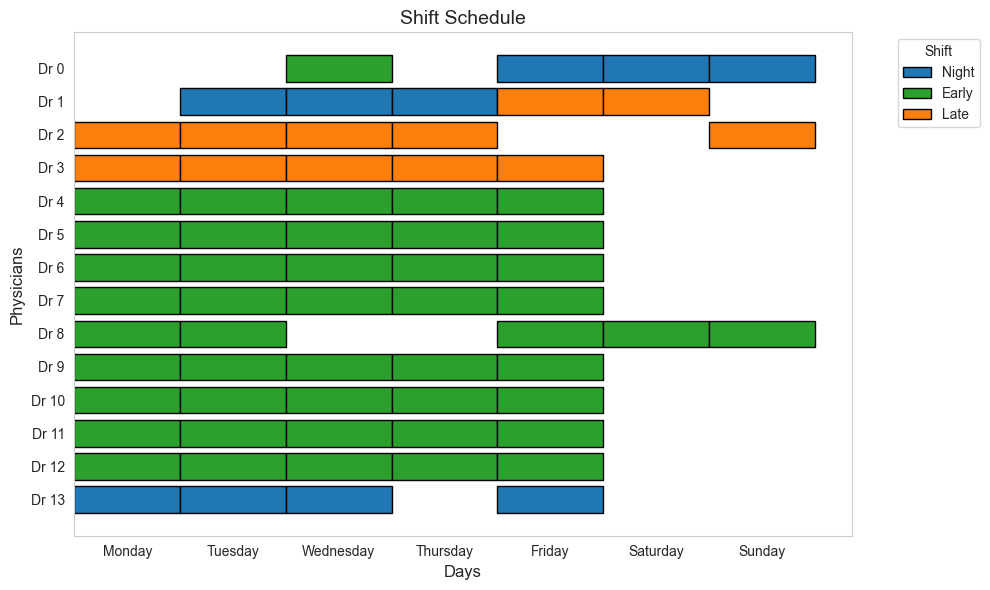

In [1082]:
# Create a visual representation of the physician shift schedule
# Gantt diagramm
gantt_data = []
for p in reduced_physicians:
    for d_idx, d in enumerate(DAYS):
        for s in SHIFTS:
            if x[p, d, s].X > 0.5:
                gantt_data.append((f"Dr {p}", d_idx, s))

fig, ax = plt.subplots(figsize=(10, 6))

# Draw bars for each shift
used_labels = set()
for doctor, day_idx, shift in gantt_data:
    label = shift if shift not in used_labels else None
    ax.barh(
        doctor,
        1,
        left=day_idx,
        color=shift_colors[shift],
        edgecolor="black",
        label=label
    )
    used_labels.add(shift)

# Title
ax.set_xlabel("Days", fontsize=12)
ax.set_ylabel("Physicians", fontsize=12)
ax.set_title("Shift Schedule", fontsize=14)

ax.set_xticks([i + 0.5 for i in range(len(DAYS))])
ax.set_xticklabels(DAYS, fontsize=10)

ax.set_yticks(range(len(reduced_physicians)))
ax.set_yticklabels([f"Dr {p}" for p in reduced_physicians[::-1]], fontsize=10)

ax.grid(False)

ax.legend(title="Shift", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

### Results

1. **Optimal Number of Physicians**:
   - The model determined that the minimum number of physicians required to meet all constraints and cover all demand is **14 physicians**.

2. **Schedule Details**:
   - The schedule is fully aligned with demand patterns and adheres to all constraints:
     - **Workload Limitation**: No physician is assigned more than **5 shifts per week**, adhering to the 40-hour weekly limit.
     - **Rest Days**: Every physician is guaranteed at least **2 consecutive days off** during the week, ensuring compliance with work-life balance requirements.
     - **Shift Type Restriction**: Physicians are limited to working at most **2 types of shifts per week** (e.g., Early and Late, Late and Night).
     - **Rest Period**: The mandatory **10-hour rest period** between shifts is strictly enforced, including transitions from Sunday to Monday.
     - **Night Shift Limitation**: No physician works more than **3 consecutive night shifts**, including cyclic transitions.
   - The schedule is designed to be **cyclic**, ensuring continuity from one week to the next while adhering to all constraints.


## Question 3 <a name="Question3"></a>

## Question 4 <a name="Question4"></a>

## Question 5 <a name="Question5"></a>